# **HPa** 
---
☣
**Simulador de partículas com features de:**
* Atração;
* Repulsão;
* Limites de parede;

## IMPORTS

In [336]:
#### IMPORT DE BIBLIOTECAS
from matplotlib import rc
rc('animation', html='jshtml')

In [337]:
from math import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.animation as animation
import pandas as pd
from google.colab import auth

import gspread
from google.auth import default

## FUNÇÕES

In [338]:
def frame(w):
    """Define a localização do frame atual e plota o gráfico"""
    ax.clear()
    global N,df,passo
    
    df = position(N,df,passo)

    x = df['x_i+1']
    y = df['y_i+1']
    carga = df['carga']
    carga_valor = df['carga_valor']

    plt.title("Particle Motion")
    ax.set_xlabel('X(t)')
    ax.set_xlim(0,larg)
    ax.set_ylabel('Y(t)')
    ax.set_ylim(0,larg)
   
    colors = {'positivo':'red', 'negativo':'blue'}
    plot = ax.scatter(x, y, c=df['carga'].map(colors))

    return plot

In [339]:
def position(N,df,passo):
    """Pega a posição atual das partículas e retorna a próxima posição"""
    global G

    for partic in range(0,len(df.index)):
      # force reset
      Fx = Fy = 0

      # ATRAÇÃO E REPULSÃO EIXO X E Y
      Fx, theta = forca_atracao_repulsao(Fx, 'x', df, partic)
      Fy, theta = forca_atracao_repulsao(Fy, 'y', df, partic)

      df.at[partic,'Fx'] = Fx
      df.at[partic,'Fy'] = Fy
      df.at[partic,'Theta'] = theta

    # PRÓXIMA POSIÇÃO
    df['x_i+1'] = df['x_i'] + passo * df['Fx'] 
    df['y_i+1'] = df['y_i'] + passo * df['Fy']

    # EFEITO LIMITE FÍSICO DE BORDA
    df.loc[df['x_i+1'] > (larg)*0.99, 'x_i+1'] = (larg)*0.99
    df.loc[df['y_i+1'] > (larg)*0.99, 'y_i+1'] = (larg)*0.99
    df.loc[df['x_i+1'] < 0, 'x_i+1'] = 0
    df.loc[df['y_i+1'] < 0, 'y_i+1'] = 0

    # ATUALIZAÇÃO DA NOVA POSIÇÃO
    df['x_i'] = df['x_i+1']
    df['y_i'] = df['y_i+1']

    display(df)
    print('\n')

    return df

In [340]:
def forca_atracao_repulsao(F, eixo, df , partic):
  """calcula a força de atração e repulsão no eixo em questão"""
  for interacao in range(0,len(df.index)):

    # DISTANCIA ENTRE PARTICULAS (r) E DIREÇÃO DA FORÇA (dir)
    rx = (df['x_i'][interacao] - df['x_i'][partic])
    ry = (df['y_i'][interacao] - df['y_i'][partic])
    rx_abs = abs(rx)
    ry_abs = abs(ry)

    try:
      r = (rx**2 + ry**2)**(0.5)
    except:
      r = 0

    dirx = 1*(rx >= 0) + (-1)*(rx < 0)
    diry = 1*(ry >= 0) + (-1)*(ry < 0)

    if rx_abs != 0:
      theta = np.arctan(ry_abs/rx_abs)
    else:
      theta = 0

    # DESCOBRIR A CARGA DE CADA PARTICULA
    Q1_carga = 1*(df['carga'][partic]    == 'positivo') + (-1)*(df['carga'][partic]    == 'negativo')
    Q2_carga = 1*(df['carga'][interacao] == 'positivo') + (-1)*(df['carga'][interacao] == 'negativo')

    # APLICAR A CARGA (+ OU -) PARA O VALOR DE CARGA DE PARTICULA
    Q1 = Q1_carga * df['carga_valor'][partic]
    Q2 = Q2_carga * df['carga_valor'][interacao]

    # CÁLCULO DE FORÇA
    if r == 0:
      pass
    elif eixo == 'x':
      F = F + (np.cos(theta))*(dirx)*(-G)*Q1*Q2/r**2
    elif eixo == 'y':
      F = F + (np.sin(theta))*(diry)*(-G)*Q1*Q2/r**2

  if   eixo == 'x':
    return F, theta
  elif eixo == 'y':
    return F, theta

## CONDIÇÕES DE CONTORNO INICIAIS

* N: número de partículas
* x: posição no eixo x
* y: posição no eixo y


In [341]:
# COEFICIENTE DE ATRAÇÃO E REPULSÃO
G = 8.99*10**9  # [N.m²/C²]

# Dados crus para dataframe:
auth.authenticate_user()

creds, _ = default()

gc = gspread.authorize(creds)

worksheet = gc.open('condicoes_iniciais_HPa').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

df_GDrive = pd.DataFrame.from_records(rows)

new_header = df_GDrive.iloc[0] #grab the first row for the header
df_GDrive = df_GDrive[1:]         #take the data less the header row
df_GDrive.columns = new_header #set the header row as the df header

df_GDrive = df_GDrive.fillna('')
df_GDrive = df_GDrive.rename(columns={'carga_valor [C]': 'carga_valor', 
                                      'forca_x [N]': 'Fx',
                                      'forca_y [N]': 'Fy',
                                      'posicao_x [m]': 'x_i',
                                      'posicao_y [m]': 'y_i',
                                      'vel_x [m/s]': 'Vx',
                                      'vel_y [m/s]': 'Vy',
                                      'acel_x [m/s2]': 'Ax',
                                      'acel_y [m/s2]': 'Ay',
                                      'passo [s]': 'passo',
                                      'largura [m]': 'larg'
                                      })

for n in df_GDrive.columns:
  if (n == 'carga') or (n == 'passo') or (n == 'larg'):
    pass
  else:
    df_GDrive[n] = df_GDrive[n].str.replace(',','.').astype(float)

N = (len(df_GDrive))
passo = float(df_GDrive['passo'][1].replace(',','.'))
larg =  float(df_GDrive['larg'][1].replace(',','.'))

df_GDrive = df_GDrive.drop(['passo', 'larg'], axis=1)
df_GDrive = df_GDrive.reset_index(drop=True)


In [342]:
df = df_GDrive.copy()
df.head()

0     carga  carga_valor  x_i  y_i   Fx   Fy   Vx   Vy   Ax   Ay
0  positivo     0.000002  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
1  negativo     0.000004  1.1  1.1  0.0  0.0  0.0  0.0  0.0  0.0

### CRIAÇÃO DO AMBIENTE DE PLOTAGEM

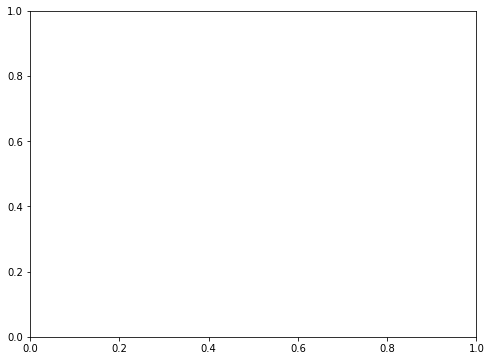

In [343]:
fig = plt.figure(figsize=(8,6))
ax = plt.axes()


## ANIMAÇÃO EM TRANSIENTE

In [344]:
anim = animation.FuncAnimation(fig, frame, frames=200, blit=False, repeat=True)

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  1.001271  1.001271  2.542756  2.542756  0.0  0.0   
1  negativo     0.000004  1.098729  1.098729 -2.542756 -2.542756  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  1.001271  1.001271  
1  0.0  0.0  0.000000  1.098729  1.098729

0     carga  carga_valor      x_i      y_i        Fx        Fy   Vx   Vy   Ax  \
0  positivo     0.000002  1.00261  1.00261  2.677173  2.677173  0.0  0.0  0.0   
1  negativo     0.000004  1.09739  1.09739 -2.677173 -2.677173  0.0  0.0  0.0   

0   Ay     Theta    x_i+1    y_i+1  
0  0.0  0.785398  1.00261  1.00261  
1  0.0  0.000000  1.09739  1.09739

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  1.004025  1.004025  2.830549  2.830549  0.0  0.0   
1  negativo     0.000004  1.095975  1.095975 -2.830549 -2.830549  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  1.004025  1.004025  
1  0.0  0.0  0.000000  1.095975  1.095975

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  1.005529  1.005529  3.007501  3.007501  0.0  0.0   
1  negativo     0.000004  1.094471  1.094471 -3.007501 -3.007501  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  1.005529  1.005529  
1  0.0  0.0  0.000000  1.094471  1.094471

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  1.007136  1.007136  3.214332  3.214332  0.0  0.0   
1  negativo     0.000004  1.092864  1.092864 -3.214332 -3.214332  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  1.007136  1.007136  
1  0.0  0.0  0.000000  1.092864  1.092864

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  1.008866  1.008866  3.459891  3.459891  0.0  0.0   
1  negativo     0.000004  1.091134  1.091134 -3.459891 -3.459891  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  1.008866  1.008866  
1  0.0  0.0  0.000000  1.091134  1.091134

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  1.010745  1.010745  3.757032  3.757032  0.0  0.0   
1  negativo     0.000004  1.089255  1.089255 -3.757032 -3.757032  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  1.010745  1.010745  
1  0.0  0.0  0.000000  1.089255  1.089255

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  1.012807  1.012807  4.125212  4.125212  0.0  0.0   
1  negativo     0.000004  1.087193  1.087193 -4.125212 -4.125212  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  1.012807  1.012807  
1  0.0  0.0  0.000000  1.087193  1.087193

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  1.015105  1.015105  4.595444  4.595444  0.0  0.0   
1  negativo     0.000004  1.084895  1.084895 -4.595444 -4.595444  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  1.015105  1.015105  
1  0.0  0.0  0.000000  1.084895  1.084895

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  1.017715  1.017715  5.220558  5.220558  0.0  0.0   
1  negativo     0.000004  1.082285  1.082285 -5.220558 -5.220558  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  1.017715  1.017715  
1  0.0  0.0  0.000000  1.082285  1.082285

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  1.020765  1.020765  6.098866  6.098866  0.0  0.0   
1  negativo     0.000004  1.079235  1.079235 -6.098866 -6.098866  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  1.020765  1.020765  
1  0.0  0.0  0.000000  1.079235  1.079235

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  1.024483  1.024483  7.437523  7.437523  0.0  0.0   
1  negativo     0.000004  1.075517  1.075517 -7.437523 -7.437523  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  1.024483  1.024483  
1  0.0  0.0  0.000000  1.075517  1.075517

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  1.029365  1.029365  9.763369  9.763369  0.0  0.0   
1  negativo     0.000004  1.070635  1.070635 -9.763369 -9.763369  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  1.029365  1.029365  
1  0.0  0.0  0.000000  1.070635  1.070635

0     carga  carga_valor      x_i      y_i         Fx         Fy   Vx   Vy  \
0  positivo     0.000002  1.03683  1.03683  14.929321  14.929321  0.0  0.0   
1  negativo     0.000004  1.06317  1.06317 -14.929321 -14.929321  0.0  0.0   

0   Ax   Ay     Theta    x_i+1    y_i+1  
0  0.0  0.0  0.785398  1.03683  1.03683  
1  0.0  0.0  0.000000  1.06317  1.06317

0     carga  carga_valor       x_i       y_i         Fx         Fy   Vx   Vy  \
0  positivo     0.000002  1.055154  1.055154  36.648611  36.648611  0.0  0.0   
1  negativo     0.000004  1.044846  1.044846 -36.648611 -36.648611  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  1.055154  1.055154  
1  0.0  0.0  0.000000  1.044846  1.044846

0     carga  carga_valor       x_i       y_i         Fx         Fy   Vx   Vy  \
0  positivo     0.000002  0.935504  0.935504 -239.30087 -239.30087  0.0  0.0   
1  negativo     0.000004  1.164496  1.164496  239.30087  239.30087  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.935504  0.935504  
1  0.0  0.0  0.000000  1.164496  1.164496

0     carga  carga_valor       x_i       y_i       Fx       Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.935746  0.935746  0.48491  0.48491  0.0  0.0  0.0   
1  negativo     0.000004  1.164254  1.164254 -0.48491 -0.48491  0.0  0.0  0.0   

0   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.785398  0.935746  0.935746  
1  0.0  0.000000  1.164254  1.164254

0     carga  carga_valor      x_i      y_i       Fx       Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.93599  0.93599  0.48697  0.48697  0.0  0.0  0.0   
1  negativo     0.000004  1.16401  1.16401 -0.48697 -0.48697  0.0  0.0  0.0   

0   Ay     Theta    x_i+1    y_i+1  
0  0.0  0.785398  0.93599  0.93599  
1  0.0  0.000000  1.16401  1.16401

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.936234  0.936234  0.489053  0.489053  0.0  0.0   
1  negativo     0.000004  1.163766  1.163766 -0.489053 -0.489053  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.936234  0.936234  
1  0.0  0.0  0.000000  1.163766  1.163766

0     carga  carga_valor      x_i      y_i        Fx        Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.93648  0.93648  0.491157  0.491157  0.0  0.0  0.0   
1  negativo     0.000004  1.16352  1.16352 -0.491157 -0.491157  0.0  0.0  0.0   

0   Ay     Theta    x_i+1    y_i+1  
0  0.0  0.785398  0.93648  0.93648  
1  0.0  0.000000  1.16352  1.16352

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.936726  0.936726  0.493285  0.493285  0.0  0.0   
1  negativo     0.000004  1.163274  1.163274 -0.493285 -0.493285  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.936726  0.936726  
1  0.0  0.0  0.000000  1.163274  1.163274

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.936974  0.936974  0.495435  0.495435  0.0  0.0   
1  negativo     0.000004  1.163026  1.163026 -0.495435 -0.495435  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.936974  0.936974  
1  0.0  0.0  0.000000  1.163026  1.163026

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.937223  0.937223  0.497609  0.497609  0.0  0.0   
1  negativo     0.000004  1.162777  1.162777 -0.497609 -0.497609  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.937223  0.937223  
1  0.0  0.0  0.000000  1.162777  1.162777

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.937473  0.937473  0.499807  0.499807  0.0  0.0   
1  negativo     0.000004  1.162527  1.162527 -0.499807 -0.499807  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.937473  0.937473  
1  0.0  0.0  0.000000  1.162527  1.162527

0     carga  carga_valor       x_i       y_i       Fx       Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.937724  0.937724  0.50203  0.50203  0.0  0.0  0.0   
1  negativo     0.000004  1.162276  1.162276 -0.50203 -0.50203  0.0  0.0  0.0   

0   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.785398  0.937724  0.937724  
1  0.0  0.000000  1.162276  1.162276

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.937976  0.937976  0.504277  0.504277  0.0  0.0   
1  negativo     0.000004  1.162024  1.162024 -0.504277 -0.504277  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.937976  0.937976  
1  0.0  0.0  0.000000  1.162024  1.162024

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.938229  0.938229  0.506549  0.506549  0.0  0.0   
1  negativo     0.000004  1.161771  1.161771 -0.506549 -0.506549  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.938229  0.938229  
1  0.0  0.0  0.000000  1.161771  1.161771

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.938484  0.938484  0.508848  0.508848  0.0  0.0   
1  negativo     0.000004  1.161516  1.161516 -0.508848 -0.508848  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.938484  0.938484  
1  0.0  0.0  0.000000  1.161516  1.161516

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.938739  0.938739  0.511172  0.511172  0.0  0.0   
1  negativo     0.000004  1.161261  1.161261 -0.511172 -0.511172  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.938739  0.938739  
1  0.0  0.0  0.000000  1.161261  1.161261

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.938996  0.938996  0.513523  0.513523  0.0  0.0   
1  negativo     0.000004  1.161004  1.161004 -0.513523 -0.513523  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.938996  0.938996  
1  0.0  0.0  0.000000  1.161004  1.161004

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.939254  0.939254  0.515902  0.515902  0.0  0.0   
1  negativo     0.000004  1.160746  1.160746 -0.515902 -0.515902  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.939254  0.939254  
1  0.0  0.0  0.000000  1.160746  1.160746

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.939513  0.939513  0.518308  0.518308  0.0  0.0   
1  negativo     0.000004  1.160487  1.160487 -0.518308 -0.518308  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.939513  0.939513  
1  0.0  0.0  0.000000  1.160487  1.160487

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.939773  0.939773  0.520742  0.520742  0.0  0.0   
1  negativo     0.000004  1.160227  1.160227 -0.520742 -0.520742  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.939773  0.939773  
1  0.0  0.0  0.000000  1.160227  1.160227

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.940035  0.940035  0.523205  0.523205  0.0  0.0   
1  negativo     0.000004  1.159965  1.159965 -0.523205 -0.523205  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.940035  0.940035  
1  0.0  0.0  0.000000  1.159965  1.159965

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.940298  0.940298  0.525698  0.525698  0.0  0.0   
1  negativo     0.000004  1.159702  1.159702 -0.525698 -0.525698  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.940298  0.940298  
1  0.0  0.0  0.000000  1.159702  1.159702

0     carga  carga_valor       x_i       y_i       Fx       Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.940562  0.940562  0.52822  0.52822  0.0  0.0  0.0   
1  negativo     0.000004  1.159438  1.159438 -0.52822 -0.52822  0.0  0.0  0.0   

0   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.785398  0.940562  0.940562  
1  0.0  0.000000  1.159438  1.159438

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.940827  0.940827  0.530772  0.530772  0.0  0.0   
1  negativo     0.000004  1.159173  1.159173 -0.530772 -0.530772  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.940827  0.940827  
1  0.0  0.0  0.000000  1.159173  1.159173

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.941094  0.941094  0.533356  0.533356  0.0  0.0   
1  negativo     0.000004  1.158906  1.158906 -0.533356 -0.533356  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.941094  0.941094  
1  0.0  0.0  0.000000  1.158906  1.158906

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.941362  0.941362  0.535971  0.535971  0.0  0.0   
1  negativo     0.000004  1.158638  1.158638 -0.535971 -0.535971  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.941362  0.941362  
1  0.0  0.0  0.000000  1.158638  1.158638

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.941631  0.941631  0.538619  0.538619  0.0  0.0   
1  negativo     0.000004  1.158369  1.158369 -0.538619 -0.538619  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.941631  0.941631  
1  0.0  0.0  0.000000  1.158369  1.158369

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.941902  0.941902  0.541299  0.541299  0.0  0.0   
1  negativo     0.000004  1.158098  1.158098 -0.541299 -0.541299  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.941902  0.941902  
1  0.0  0.0  0.000000  1.158098  1.158098

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.942174  0.942174  0.544013  0.544013  0.0  0.0   
1  negativo     0.000004  1.157826  1.157826 -0.544013 -0.544013  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.942174  0.942174  
1  0.0  0.0  0.000000  1.157826  1.157826

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.942447  0.942447  0.546761  0.546761  0.0  0.0   
1  negativo     0.000004  1.157553  1.157553 -0.546761 -0.546761  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.942447  0.942447  
1  0.0  0.0  0.000000  1.157553  1.157553

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.942722  0.942722  0.549544  0.549544  0.0  0.0   
1  negativo     0.000004  1.157278  1.157278 -0.549544 -0.549544  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.942722  0.942722  
1  0.0  0.0  0.000000  1.157278  1.157278

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.942998  0.942998  0.552363  0.552363  0.0  0.0   
1  negativo     0.000004  1.157002  1.157002 -0.552363 -0.552363  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.942998  0.942998  
1  0.0  0.0  0.000000  1.157002  1.157002

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.943276  0.943276  0.555218  0.555218  0.0  0.0   
1  negativo     0.000004  1.156724  1.156724 -0.555218 -0.555218  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.943276  0.943276  
1  0.0  0.0  0.000000  1.156724  1.156724

0     carga  carga_valor       x_i       y_i       Fx       Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.943555  0.943555  0.55811  0.55811  0.0  0.0  0.0   
1  negativo     0.000004  1.156445  1.156445 -0.55811 -0.55811  0.0  0.0  0.0   

0   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.785398  0.943555  0.943555  
1  0.0  0.000000  1.156445  1.156445

0     carga  carga_valor       x_i       y_i       Fx       Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.943836  0.943836  0.56104  0.56104  0.0  0.0  0.0   
1  negativo     0.000004  1.156164  1.156164 -0.56104 -0.56104  0.0  0.0  0.0   

0   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.785398  0.943836  0.943836  
1  0.0  0.000000  1.156164  1.156164

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.944118  0.944118  0.564009  0.564009  0.0  0.0   
1  negativo     0.000004  1.155882  1.155882 -0.564009 -0.564009  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.944118  0.944118  
1  0.0  0.0  0.000000  1.155882  1.155882

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.944401  0.944401  0.567018  0.567018  0.0  0.0   
1  negativo     0.000004  1.155599  1.155599 -0.567018 -0.567018  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.944401  0.944401  
1  0.0  0.0  0.000000  1.155599  1.155599

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.944686  0.944686  0.570066  0.570066  0.0  0.0   
1  negativo     0.000004  1.155314  1.155314 -0.570066 -0.570066  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.944686  0.944686  
1  0.0  0.0  0.000000  1.155314  1.155314

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.944973  0.944973  0.573156  0.573156  0.0  0.0   
1  negativo     0.000004  1.155027  1.155027 -0.573156 -0.573156  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.944973  0.944973  
1  0.0  0.0  0.000000  1.155027  1.155027

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.945261  0.945261  0.576288  0.576288  0.0  0.0   
1  negativo     0.000004  1.154739  1.154739 -0.576288 -0.576288  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.945261  0.945261  
1  0.0  0.0  0.000000  1.154739  1.154739

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.945551  0.945551  0.579463  0.579463  0.0  0.0   
1  negativo     0.000004  1.154449  1.154449 -0.579463 -0.579463  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.945551  0.945551  
1  0.0  0.0  0.000000  1.154449  1.154449

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.945842  0.945842  0.582683  0.582683  0.0  0.0   
1  negativo     0.000004  1.154158  1.154158 -0.582683 -0.582683  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.945842  0.945842  
1  0.0  0.0  0.000000  1.154158  1.154158

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.946135  0.946135  0.585947  0.585947  0.0  0.0   
1  negativo     0.000004  1.153865  1.153865 -0.585947 -0.585947  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.946135  0.946135  
1  0.0  0.0  0.000000  1.153865  1.153865

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.946429  0.946429  0.589257  0.589257  0.0  0.0   
1  negativo     0.000004  1.153571  1.153571 -0.589257 -0.589257  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.946429  0.946429  
1  0.0  0.0  0.000000  1.153571  1.153571

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.946726  0.946726  0.592614  0.592614  0.0  0.0   
1  negativo     0.000004  1.153274  1.153274 -0.592614 -0.592614  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.946726  0.946726  
1  0.0  0.0  0.000000  1.153274  1.153274

0     carga  carga_valor       x_i       y_i       Fx       Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.947024  0.947024  0.59602  0.59602  0.0  0.0  0.0   
1  negativo     0.000004  1.152976  1.152976 -0.59602 -0.59602  0.0  0.0  0.0   

0   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.785398  0.947024  0.947024  
1  0.0  0.000000  1.152976  1.152976

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.947324  0.947324  0.599475  0.599475  0.0  0.0   
1  negativo     0.000004  1.152676  1.152676 -0.599475 -0.599475  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.947324  0.947324  
1  0.0  0.0  0.000000  1.152676  1.152676

0     carga  carga_valor       x_i       y_i       Fx       Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.947625  0.947625  0.60298  0.60298  0.0  0.0  0.0   
1  negativo     0.000004  1.152375  1.152375 -0.60298 -0.60298  0.0  0.0  0.0   

0   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.785398  0.947625  0.947625  
1  0.0  0.000000  1.152375  1.152375

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.947928  0.947928  0.606536  0.606536  0.0  0.0   
1  negativo     0.000004  1.152072  1.152072 -0.606536 -0.606536  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.947928  0.947928  
1  0.0  0.0  0.000000  1.152072  1.152072

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.948233  0.948233  0.610146  0.610146  0.0  0.0   
1  negativo     0.000004  1.151767  1.151767 -0.610146 -0.610146  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.948233  0.948233  
1  0.0  0.0  0.000000  1.151767  1.151767

0     carga  carga_valor      x_i      y_i       Fx       Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.94854  0.94854  0.61381  0.61381  0.0  0.0  0.0   
1  negativo     0.000004  1.15146  1.15146 -0.61381 -0.61381  0.0  0.0  0.0   

0   Ay     Theta    x_i+1    y_i+1  
0  0.0  0.785398  0.94854  0.94854  
1  0.0  0.000000  1.15146  1.15146

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.948849  0.948849  0.617529  0.617529  0.0  0.0   
1  negativo     0.000004  1.151151  1.151151 -0.617529 -0.617529  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.948849  0.948849  
1  0.0  0.0  0.000000  1.151151  1.151151

0     carga  carga_valor      x_i      y_i        Fx        Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.94916  0.94916  0.621304  0.621304  0.0  0.0  0.0   
1  negativo     0.000004  1.15084  1.15084 -0.621304 -0.621304  0.0  0.0  0.0   

0   Ay     Theta    x_i+1    y_i+1  
0  0.0  0.785398  0.94916  0.94916  
1  0.0  0.000000  1.15084  1.15084

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.949472  0.949472  0.625138  0.625138  0.0  0.0   
1  negativo     0.000004  1.150528  1.150528 -0.625138 -0.625138  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.949472  0.949472  
1  0.0  0.0  0.000000  1.150528  1.150528

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.949787  0.949787  0.629032  0.629032  0.0  0.0   
1  negativo     0.000004  1.150213  1.150213 -0.629032 -0.629032  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.949787  0.949787  
1  0.0  0.0  0.000000  1.150213  1.150213

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.950103  0.950103  0.632986  0.632986  0.0  0.0   
1  negativo     0.000004  1.149897  1.149897 -0.632986 -0.632986  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.950103  0.950103  
1  0.0  0.0  0.000000  1.149897  1.149897

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.950422  0.950422  0.637004  0.637004  0.0  0.0   
1  negativo     0.000004  1.149578  1.149578 -0.637004 -0.637004  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.950422  0.950422  
1  0.0  0.0  0.000000  1.149578  1.149578

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.950742  0.950742  0.641085  0.641085  0.0  0.0   
1  negativo     0.000004  1.149258  1.149258 -0.641085 -0.641085  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.950742  0.950742  
1  0.0  0.0  0.000000  1.149258  1.149258

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.951065  0.951065  0.645232  0.645232  0.0  0.0   
1  negativo     0.000004  1.148935  1.148935 -0.645232 -0.645232  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.951065  0.951065  
1  0.0  0.0  0.000000  1.148935  1.148935

0     carga  carga_valor      x_i      y_i        Fx        Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.95139  0.95139  0.649447  0.649447  0.0  0.0  0.0   
1  negativo     0.000004  1.14861  1.14861 -0.649447 -0.649447  0.0  0.0  0.0   

0   Ay     Theta    x_i+1    y_i+1  
0  0.0  0.785398  0.95139  0.95139  
1  0.0  0.000000  1.14861  1.14861

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.951716  0.951716  0.653732  0.653732  0.0  0.0   
1  negativo     0.000004  1.148284  1.148284 -0.653732 -0.653732  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.951716  0.951716  
1  0.0  0.0  0.000000  1.148284  1.148284

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.952046  0.952046  0.658087  0.658087  0.0  0.0   
1  negativo     0.000004  1.147954  1.147954 -0.658087 -0.658087  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.952046  0.952046  
1  0.0  0.0  0.000000  1.147954  1.147954

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.952377  0.952377  0.662516  0.662516  0.0  0.0   
1  negativo     0.000004  1.147623  1.147623 -0.662516 -0.662516  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.952377  0.952377  
1  0.0  0.0  0.000000  1.147623  1.147623

0     carga  carga_valor      x_i      y_i       Fx       Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.95271  0.95271  0.66702  0.66702  0.0  0.0  0.0   
1  negativo     0.000004  1.14729  1.14729 -0.66702 -0.66702  0.0  0.0  0.0   

0   Ay     Theta    x_i+1    y_i+1  
0  0.0  0.785398  0.95271  0.95271  
1  0.0  0.000000  1.14729  1.14729

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.953046  0.953046  0.671601  0.671601  0.0  0.0   
1  negativo     0.000004  1.146954  1.146954 -0.671601 -0.671601  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.953046  0.953046  
1  0.0  0.0  0.000000  1.146954  1.146954

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.953384  0.953384  0.676261  0.676261  0.0  0.0   
1  negativo     0.000004  1.146616  1.146616 -0.676261 -0.676261  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.953384  0.953384  
1  0.0  0.0  0.000000  1.146616  1.146616

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.953725  0.953725  0.681003  0.681003  0.0  0.0   
1  negativo     0.000004  1.146275  1.146275 -0.681003 -0.681003  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.953725  0.953725  
1  0.0  0.0  0.000000  1.146275  1.146275

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.954068  0.954068  0.685828  0.685828  0.0  0.0   
1  negativo     0.000004  1.145932  1.145932 -0.685828 -0.685828  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.954068  0.954068  
1  0.0  0.0  0.000000  1.145932  1.145932

0     carga  carga_valor       x_i       y_i       Fx       Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.954413  0.954413  0.69074  0.69074  0.0  0.0  0.0   
1  negativo     0.000004  1.145587  1.145587 -0.69074 -0.69074  0.0  0.0  0.0   

0   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.785398  0.954413  0.954413  
1  0.0  0.000000  1.145587  1.145587

0     carga  carga_valor       x_i       y_i       Fx       Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.954761  0.954761  0.69574  0.69574  0.0  0.0  0.0   
1  negativo     0.000004  1.145239  1.145239 -0.69574 -0.69574  0.0  0.0  0.0   

0   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.785398  0.954761  0.954761  
1  0.0  0.000000  1.145239  1.145239

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.955111  0.955111  0.700832  0.700832  0.0  0.0   
1  negativo     0.000004  1.144889  1.144889 -0.700832 -0.700832  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.955111  0.955111  
1  0.0  0.0  0.000000  1.144889  1.144889

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.955464  0.955464  0.706018  0.706018  0.0  0.0   
1  negativo     0.000004  1.144536  1.144536 -0.706018 -0.706018  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.955464  0.955464  
1  0.0  0.0  0.000000  1.144536  1.144536

0     carga  carga_valor      x_i      y_i        Fx        Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.95582  0.95582  0.711301  0.711301  0.0  0.0  0.0   
1  negativo     0.000004  1.14418  1.14418 -0.711301 -0.711301  0.0  0.0  0.0   

0   Ay     Theta    x_i+1    y_i+1  
0  0.0  0.785398  0.95582  0.95582  
1  0.0  0.000000  1.14418  1.14418

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.956178  0.956178  0.716683  0.716683  0.0  0.0   
1  negativo     0.000004  1.143822  1.143822 -0.716683 -0.716683  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.956178  0.956178  
1  0.0  0.0  0.000000  1.143822  1.143822

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.956539  0.956539  0.722168  0.722168  0.0  0.0   
1  negativo     0.000004  1.143461  1.143461 -0.722168 -0.722168  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.956539  0.956539  
1  0.0  0.0  0.000000  1.143461  1.143461

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.956903  0.956903  0.727759  0.727759  0.0  0.0   
1  negativo     0.000004  1.143097  1.143097 -0.727759 -0.727759  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.956903  0.956903  
1  0.0  0.0  0.000000  1.143097  1.143097

0     carga  carga_valor      x_i      y_i        Fx        Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.95727  0.95727  0.733459  0.733459  0.0  0.0  0.0   
1  negativo     0.000004  1.14273  1.14273 -0.733459 -0.733459  0.0  0.0  0.0   

0   Ay     Theta    x_i+1    y_i+1  
0  0.0  0.785398  0.95727  0.95727  
1  0.0  0.000000  1.14273  1.14273

0     carga  carga_valor      x_i      y_i        Fx        Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.95764  0.95764  0.739272  0.739272  0.0  0.0  0.0   
1  negativo     0.000004  1.14236  1.14236 -0.739272 -0.739272  0.0  0.0  0.0   

0   Ay     Theta    x_i+1    y_i+1  
0  0.0  0.785398  0.95764  0.95764  
1  0.0  0.000000  1.14236  1.14236

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.958012  0.958012  0.745201  0.745201  0.0  0.0   
1  negativo     0.000004  1.141988  1.141988 -0.745201 -0.745201  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.958012  0.958012  
1  0.0  0.0  0.000000  1.141988  1.141988

0     carga  carga_valor       x_i       y_i       Fx       Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.958388  0.958388  0.75125  0.75125  0.0  0.0  0.0   
1  negativo     0.000004  1.141612  1.141612 -0.75125 -0.75125  0.0  0.0  0.0   

0   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.785398  0.958388  0.958388  
1  0.0  0.000000  1.141612  1.141612

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.958767  0.958767  0.757423  0.757423  0.0  0.0   
1  negativo     0.000004  1.141233  1.141233 -0.757423 -0.757423  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.958767  0.958767  
1  0.0  0.0  0.000000  1.141233  1.141233

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.959148  0.959148  0.763725  0.763725  0.0  0.0   
1  negativo     0.000004  1.140852  1.140852 -0.763725 -0.763725  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.959148  0.959148  
1  0.0  0.0  0.000000  1.140852  1.140852

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.959534  0.959534  0.770158  0.770158  0.0  0.0   
1  negativo     0.000004  1.140466  1.140466 -0.770158 -0.770158  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.959534  0.959534  
1  0.0  0.0  0.000000  1.140466  1.140466

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.959922  0.959922  0.776729  0.776729  0.0  0.0   
1  negativo     0.000004  1.140078  1.140078 -0.776729 -0.776729  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.959922  0.959922  
1  0.0  0.0  0.000000  1.140078  1.140078

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.960314  0.960314  0.783441  0.783441  0.0  0.0   
1  negativo     0.000004  1.139686  1.139686 -0.783441 -0.783441  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.960314  0.960314  
1  0.0  0.0  0.000000  1.139686  1.139686

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.960709  0.960709  0.790299  0.790299  0.0  0.0   
1  negativo     0.000004  1.139291  1.139291 -0.790299 -0.790299  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.960709  0.960709  
1  0.0  0.0  0.000000  1.139291  1.139291

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.961107  0.961107  0.797309  0.797309  0.0  0.0   
1  negativo     0.000004  1.138893  1.138893 -0.797309 -0.797309  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.961107  0.961107  
1  0.0  0.0  0.000000  1.138893  1.138893

0     carga  carga_valor      x_i      y_i        Fx        Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.96151  0.96151  0.804477  0.804477  0.0  0.0  0.0   
1  negativo     0.000004  1.13849  1.13849 -0.804477 -0.804477  0.0  0.0  0.0   

0   Ay     Theta    x_i+1    y_i+1  
0  0.0  0.785398  0.96151  0.96151  
1  0.0  0.000000  1.13849  1.13849

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.961916  0.961916  0.811807  0.811807  0.0  0.0   
1  negativo     0.000004  1.138084  1.138084 -0.811807 -0.811807  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.961916  0.961916  
1  0.0  0.0  0.000000  1.138084  1.138084

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.962325  0.962325  0.819306  0.819306  0.0  0.0   
1  negativo     0.000004  1.137675  1.137675 -0.819306 -0.819306  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.962325  0.962325  
1  0.0  0.0  0.000000  1.137675  1.137675

0     carga  carga_valor       x_i       y_i       Fx       Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.962739  0.962739  0.82698  0.82698  0.0  0.0  0.0   
1  negativo     0.000004  1.137261  1.137261 -0.82698 -0.82698  0.0  0.0  0.0   

0   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.785398  0.962739  0.962739  
1  0.0  0.000000  1.137261  1.137261

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.963156  0.963156  0.834836  0.834836  0.0  0.0   
1  negativo     0.000004  1.136844  1.136844 -0.834836 -0.834836  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.963156  0.963156  
1  0.0  0.0  0.000000  1.136844  1.136844

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.963578  0.963578  0.842881  0.842881  0.0  0.0   
1  negativo     0.000004  1.136422  1.136422 -0.842881 -0.842881  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.963578  0.963578  
1  0.0  0.0  0.000000  1.136422  1.136422

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.964003  0.964003  0.851121  0.851121  0.0  0.0   
1  negativo     0.000004  1.135997  1.135997 -0.851121 -0.851121  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.964003  0.964003  
1  0.0  0.0  0.000000  1.135997  1.135997

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.964433  0.964433  0.859566  0.859566  0.0  0.0   
1  negativo     0.000004  1.135567  1.135567 -0.859566 -0.859566  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.964433  0.964433  
1  0.0  0.0  0.000000  1.135567  1.135567

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.964867  0.964867  0.868222  0.868222  0.0  0.0   
1  negativo     0.000004  1.135133  1.135133 -0.868222 -0.868222  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.964867  0.964867  
1  0.0  0.0  0.000000  1.135133  1.135133

0     carga  carga_valor       x_i       y_i      Fx      Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.965306  0.965306  0.8771  0.8771  0.0  0.0  0.0   
1  negativo     0.000004  1.134694  1.134694 -0.8771 -0.8771  0.0  0.0  0.0   

0   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.785398  0.965306  0.965306  
1  0.0  0.000000  1.134694  1.134694

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.965749  0.965749  0.886206  0.886206  0.0  0.0   
1  negativo     0.000004  1.134251  1.134251 -0.886206 -0.886206  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.965749  0.965749  
1  0.0  0.0  0.000000  1.134251  1.134251

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.966196  0.966196  0.895552  0.895552  0.0  0.0   
1  negativo     0.000004  1.133804  1.133804 -0.895552 -0.895552  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.966196  0.966196  
1  0.0  0.0  0.000000  1.133804  1.133804

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.966649  0.966649  0.905148  0.905148  0.0  0.0   
1  negativo     0.000004  1.133351  1.133351 -0.905148 -0.905148  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.966649  0.966649  
1  0.0  0.0  0.000000  1.133351  1.133351

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.967107  0.967107  0.915004  0.915004  0.0  0.0   
1  negativo     0.000004  1.132893  1.132893 -0.915004 -0.915004  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.967107  0.967107  
1  0.0  0.0  0.000000  1.132893  1.132893

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.967569  0.967569  0.925132  0.925132  0.0  0.0   
1  negativo     0.000004  1.132431  1.132431 -0.925132 -0.925132  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.967569  0.967569  
1  0.0  0.0  0.000000  1.132431  1.132431

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.968037  0.968037  0.935544  0.935544  0.0  0.0   
1  negativo     0.000004  1.131963  1.131963 -0.935544 -0.935544  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.968037  0.968037  
1  0.0  0.0  0.000000  1.131963  1.131963

0     carga  carga_valor      x_i      y_i        Fx        Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.96851  0.96851  0.946253  0.946253  0.0  0.0  0.0   
1  negativo     0.000004  1.13149  1.13149 -0.946253 -0.946253  0.0  0.0  0.0   

0   Ay     Theta    x_i+1    y_i+1  
0  0.0  0.785398  0.96851  0.96851  
1  0.0  0.000000  1.13149  1.13149

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.968989  0.968989  0.957273  0.957273  0.0  0.0   
1  negativo     0.000004  1.131011  1.131011 -0.957273 -0.957273  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.968989  0.968989  
1  0.0  0.0  0.000000  1.131011  1.131011

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.969473  0.969473  0.968618  0.968618  0.0  0.0   
1  negativo     0.000004  1.130527  1.130527 -0.968618 -0.968618  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.969473  0.969473  
1  0.0  0.0  0.000000  1.130527  1.130527

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.969963  0.969963  0.980304  0.980304  0.0  0.0   
1  negativo     0.000004  1.130037  1.130037 -0.980304 -0.980304  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.969963  0.969963  
1  0.0  0.0  0.000000  1.130037  1.130037

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.970459  0.970459  0.992348  0.992348  0.0  0.0   
1  negativo     0.000004  1.129541  1.129541 -0.992348 -0.992348  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.970459  0.970459  
1  0.0  0.0  0.000000  1.129541  1.129541

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.970962  0.970962  1.004767  1.004767  0.0  0.0   
1  negativo     0.000004  1.129038  1.129038 -1.004767 -1.004767  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.970962  0.970962  
1  0.0  0.0  0.000000  1.129038  1.129038

0     carga  carga_valor      x_i      y_i       Fx       Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.97147  0.97147  1.01758  1.01758  0.0  0.0  0.0   
1  negativo     0.000004  1.12853  1.12853 -1.01758 -1.01758  0.0  0.0  0.0   

0   Ay     Theta    x_i+1    y_i+1  
0  0.0  0.785398  0.97147  0.97147  
1  0.0  0.000000  1.12853  1.12853

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.971986  0.971986  1.030809  1.030809  0.0  0.0   
1  negativo     0.000004  1.128014  1.128014 -1.030809 -1.030809  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.971986  0.971986  
1  0.0  0.0  0.000000  1.128014  1.128014

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.972508  0.972508  1.044474  1.044474  0.0  0.0   
1  negativo     0.000004  1.127492  1.127492 -1.044474 -1.044474  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.972508  0.972508  
1  0.0  0.0  0.000000  1.127492  1.127492

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.973037  0.973037  1.058599  1.058599  0.0  0.0   
1  negativo     0.000004  1.126963  1.126963 -1.058599 -1.058599  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.973037  0.973037  
1  0.0  0.0  0.000000  1.126963  1.126963

0     carga  carga_valor       x_i       y_i       Fx       Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.973574  0.973574  1.07321  1.07321  0.0  0.0  0.0   
1  negativo     0.000004  1.126426  1.126426 -1.07321 -1.07321  0.0  0.0  0.0   

0   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.785398  0.973574  0.973574  
1  0.0  0.000000  1.126426  1.126426

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.974118  0.974118  1.088334  1.088334  0.0  0.0   
1  negativo     0.000004  1.125882  1.125882 -1.088334 -1.088334  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.974118  0.974118  
1  0.0  0.0  0.000000  1.125882  1.125882

0     carga  carga_valor      x_i      y_i        Fx        Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.97467  0.97467  1.103999  1.103999  0.0  0.0  0.0   
1  negativo     0.000004  1.12533  1.12533 -1.103999 -1.103999  0.0  0.0  0.0   

0   Ay     Theta    x_i+1    y_i+1  
0  0.0  0.785398  0.97467  0.97467  
1  0.0  0.000000  1.12533  1.12533

0     carga  carga_valor      x_i      y_i        Fx        Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.97523  0.97523  1.120238  1.120238  0.0  0.0  0.0   
1  negativo     0.000004  1.12477  1.12477 -1.120238 -1.120238  0.0  0.0  0.0   

0   Ay     Theta    x_i+1    y_i+1  
0  0.0  0.785398  0.97523  0.97523  
1  0.0  0.000000  1.12477  1.12477

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.975799  0.975799  1.137085  1.137085  0.0  0.0   
1  negativo     0.000004  1.124201  1.124201 -1.137085 -1.137085  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.975799  0.975799  
1  0.0  0.0  0.000000  1.124201  1.124201

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.976376  0.976376  1.154577  1.154577  0.0  0.0   
1  negativo     0.000004  1.123624  1.123624 -1.154577 -1.154577  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.976376  0.976376  
1  0.0  0.0  0.000000  1.123624  1.123624

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.976962  0.976962  1.172754  1.172754  0.0  0.0   
1  negativo     0.000004  1.123038  1.123038 -1.172754 -1.172754  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.976962  0.976962  
1  0.0  0.0  0.000000  1.123038  1.123038

0     carga  carga_valor       x_i       y_i       Fx       Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.977558  0.977558  1.19166  1.19166  0.0  0.0  0.0   
1  negativo     0.000004  1.122442  1.122442 -1.19166 -1.19166  0.0  0.0  0.0   

0   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.785398  0.977558  0.977558  
1  0.0  0.000000  1.122442  1.122442

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.978164  0.978164  1.211344  1.211344  0.0  0.0   
1  negativo     0.000004  1.121836  1.121836 -1.211344 -1.211344  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.978164  0.978164  
1  0.0  0.0  0.000000  1.121836  1.121836

0     carga  carga_valor      x_i      y_i        Fx        Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.97878  0.97878  1.231856  1.231856  0.0  0.0  0.0   
1  negativo     0.000004  1.12122  1.12122 -1.231856 -1.231856  0.0  0.0  0.0   

0   Ay     Theta    x_i+1    y_i+1  
0  0.0  0.785398  0.97878  0.97878  
1  0.0  0.000000  1.12122  1.12122

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.979407  0.979407  1.253255  1.253255  0.0  0.0   
1  negativo     0.000004  1.120593  1.120593 -1.253255 -1.253255  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.979407  0.979407  
1  0.0  0.0  0.000000  1.120593  1.120593

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.980044  0.980044  1.275603  1.275603  0.0  0.0   
1  negativo     0.000004  1.119956  1.119956 -1.275603 -1.275603  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.980044  0.980044  
1  0.0  0.0  0.000000  1.119956  1.119956

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.980694  0.980694  1.298969  1.298969  0.0  0.0   
1  negativo     0.000004  1.119306  1.119306 -1.298969 -1.298969  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.980694  0.980694  
1  0.0  0.0  0.000000  1.119306  1.119306

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.981356  0.981356  1.323429  1.323429  0.0  0.0   
1  negativo     0.000004  1.118644  1.118644 -1.323429 -1.323429  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.981356  0.981356  
1  0.0  0.0  0.000000  1.118644  1.118644

0     carga  carga_valor      x_i      y_i        Fx        Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.98203  0.98203  1.349067  1.349067  0.0  0.0  0.0   
1  negativo     0.000004  1.11797  1.11797 -1.349067 -1.349067  0.0  0.0  0.0   

0   Ay     Theta    x_i+1    y_i+1  
0  0.0  0.785398  0.98203  0.98203  
1  0.0  0.000000  1.11797  1.11797

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.982718  0.982718  1.375976  1.375976  0.0  0.0   
1  negativo     0.000004  1.117282  1.117282 -1.375976 -1.375976  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.982718  0.982718  
1  0.0  0.0  0.000000  1.117282  1.117282

0     carga  carga_valor      x_i      y_i       Fx       Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.98342  0.98342  1.40426  1.40426  0.0  0.0  0.0   
1  negativo     0.000004  1.11658  1.11658 -1.40426 -1.40426  0.0  0.0  0.0   

0   Ay     Theta    x_i+1    y_i+1  
0  0.0  0.785398  0.98342  0.98342  
1  0.0  0.000000  1.11658  1.11658

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.984137  0.984137  1.434034  1.434034  0.0  0.0   
1  negativo     0.000004  1.115863  1.115863 -1.434034 -1.434034  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.984137  0.984137  
1  0.0  0.0  0.000000  1.115863  1.115863

0     carga  carga_valor      x_i      y_i        Fx        Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.98487  0.98487  1.465427  1.465427  0.0  0.0  0.0   
1  negativo     0.000004  1.11513  1.11513 -1.465427 -1.465427  0.0  0.0  0.0   

0   Ay     Theta    x_i+1    y_i+1  
0  0.0  0.785398  0.98487  0.98487  
1  0.0  0.000000  1.11513  1.11513

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.985619  0.985619  1.498584  1.498584  0.0  0.0   
1  negativo     0.000004  1.114381  1.114381 -1.498584 -1.498584  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.985619  0.985619  
1  0.0  0.0  0.000000  1.114381  1.114381

0     carga  carga_valor       x_i       y_i       Fx       Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.986386  0.986386  1.53367  1.53367  0.0  0.0  0.0   
1  negativo     0.000004  1.113614  1.113614 -1.53367 -1.53367  0.0  0.0  0.0   

0   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.785398  0.986386  0.986386  
1  0.0  0.000000  1.113614  1.113614

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.987171  0.987171  1.570868  1.570868  0.0  0.0   
1  negativo     0.000004  1.112829  1.112829 -1.570868 -1.570868  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.987171  0.987171  
1  0.0  0.0  0.000000  1.112829  1.112829

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.987977  0.987977  1.610389  1.610389  0.0  0.0   
1  negativo     0.000004  1.112023  1.112023 -1.610389 -1.610389  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.987977  0.987977  
1  0.0  0.0  0.000000  1.112023  1.112023

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.988803  0.988803  1.652473  1.652473  0.0  0.0   
1  negativo     0.000004  1.111197  1.111197 -1.652473 -1.652473  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.988803  0.988803  
1  0.0  0.0  0.000000  1.111197  1.111197

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.989652  0.989652  1.697395  1.697395  0.0  0.0   
1  negativo     0.000004  1.110348  1.110348 -1.697395 -1.697395  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.989652  0.989652  
1  0.0  0.0  0.000000  1.110348  1.110348

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.990524  0.990524  1.745473  1.745473  0.0  0.0   
1  negativo     0.000004  1.109476  1.109476 -1.745473 -1.745473  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.990524  0.990524  
1  0.0  0.0  0.000000  1.109476  1.109476

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.991423  0.991423  1.797074  1.797074  0.0  0.0   
1  negativo     0.000004  1.108577  1.108577 -1.797074 -1.797074  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.991423  0.991423  
1  0.0  0.0  0.000000  1.108577  1.108577

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.992349  0.992349  1.852629  1.852629  0.0  0.0   
1  negativo     0.000004  1.107651  1.107651 -1.852629 -1.852629  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.992349  0.992349  
1  0.0  0.0  0.000000  1.107651  1.107651

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.993305  0.993305  1.912642  1.912642  0.0  0.0   
1  negativo     0.000004  1.106695  1.106695 -1.912642 -1.912642  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.993305  0.993305  
1  0.0  0.0  0.000000  1.106695  1.106695

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.994294  0.994294  1.977711  1.977711  0.0  0.0   
1  negativo     0.000004  1.105706  1.105706 -1.977711 -1.977711  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.994294  0.994294  
1  0.0  0.0  0.000000  1.105706  1.105706

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.995319  0.995319  2.048549  2.048549  0.0  0.0   
1  negativo     0.000004  1.104681  1.104681 -2.048549 -2.048549  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.995319  0.995319  
1  0.0  0.0  0.000000  1.104681  1.104681

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.996382  0.996382  2.126013  2.126013  0.0  0.0   
1  negativo     0.000004  1.103618  1.103618 -2.126013 -2.126013  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.996382  0.996382  
1  0.0  0.0  0.000000  1.103618  1.103618

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.997487  0.997487  2.211147  2.211147  0.0  0.0   
1  negativo     0.000004  1.102513  1.102513 -2.211147 -2.211147  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.997487  0.997487  
1  0.0  0.0  0.000000  1.102513  1.102513

0     carga  carga_valor      x_i      y_i        Fx        Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.99864  0.99864  2.305231  2.305231  0.0  0.0  0.0   
1  negativo     0.000004  1.10136  1.10136 -2.305231 -2.305231  0.0  0.0  0.0   

0   Ay     Theta    x_i+1    y_i+1  
0  0.0  0.785398  0.99864  0.99864  
1  0.0  0.000000  1.10136  1.10136

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.999845  0.999845  2.409859  2.409859  0.0  0.0   
1  negativo     0.000004  1.100155  1.100155 -2.409859 -2.409859  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.999845  0.999845  
1  0.0  0.0  0.000000  1.100155  1.100155

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  1.001108  1.001108  2.527039  2.527039  0.0  0.0   
1  negativo     0.000004  1.098892  1.098892 -2.527039 -2.527039  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  1.001108  1.001108  
1  0.0  0.0  0.000000  1.098892  1.098892

0     carga  carga_valor       x_i       y_i       Fx       Fy   Vx   Vy   Ax  \
0  positivo     0.000002  1.002438  1.002438  2.65934  2.65934  0.0  0.0  0.0   
1  negativo     0.000004  1.097562  1.097562 -2.65934 -2.65934  0.0  0.0  0.0   

0   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.785398  1.002438  1.002438  
1  0.0  0.000000  1.097562  1.097562

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  1.003843  1.003843  2.810111  2.810111  0.0  0.0   
1  negativo     0.000004  1.096157  1.096157 -2.810111 -2.810111  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  1.003843  1.003843  
1  0.0  0.0  0.000000  1.096157  1.096157

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  1.005335  1.005335  2.983799  2.983799  0.0  0.0   
1  negativo     0.000004  1.094665  1.094665 -2.983799 -2.983799  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  1.005335  1.005335  
1  0.0  0.0  0.000000  1.094665  1.094665

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  1.006928  1.006928  3.186457  3.186457  0.0  0.0   
1  negativo     0.000004  1.093072  1.093072 -3.186457 -3.186457  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  1.006928  1.006928  
1  0.0  0.0  0.000000  1.093072  1.093072

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  1.008641  1.008641  3.426551  3.426551  0.0  0.0   
1  negativo     0.000004  1.091359  1.091359 -3.426551 -3.426551  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  1.008641  1.008641  
1  0.0  0.0  0.000000  1.091359  1.091359

0     carga  carga_valor     x_i     y_i        Fx        Fy   Vx   Vy   Ax  \
0  positivo     0.000002  1.0105  1.0105  3.716319  3.716319  0.0  0.0  0.0   
1  negativo     0.000004  1.0895  1.0895 -3.716319 -3.716319  0.0  0.0  0.0   

0   Ay     Theta   x_i+1   y_i+1  
0  0.0  0.785398  1.0105  1.0105  
1  0.0  0.000000  1.0895  1.0895

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  1.012537  1.012537  4.074186  4.074186  0.0  0.0   
1  negativo     0.000004  1.087463  1.087463 -4.074186 -4.074186  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  1.012537  1.012537  
1  0.0  0.0  0.000000  1.087463  1.087463

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  1.014801  1.014801  4.529305  4.529305  0.0  0.0   
1  negativo     0.000004  1.085199  1.085199 -4.529305 -4.529305  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  1.014801  1.014801  
1  0.0  0.0  0.000000  1.085199  1.085199

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  1.017367  1.017367  5.130877  5.130877  0.0  0.0   
1  negativo     0.000004  1.082633  1.082633 -5.130877 -5.130877  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  1.017367  1.017367  
1  0.0  0.0  0.000000  1.082633  1.082633

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  1.020351  1.020351  5.969306  5.969306  0.0  0.0   
1  negativo     0.000004  1.079649  1.079649 -5.969306 -5.969306  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  1.020351  1.020351  
1  0.0  0.0  0.000000  1.079649  1.079649

0     carga  carga_valor       x_i       y_i       Fx       Fy   Vx   Vy   Ax  \
0  positivo     0.000002  1.023967  1.023967  7.23163  7.23163  0.0  0.0  0.0   
1  negativo     0.000004  1.076033  1.076033 -7.23163 -7.23163  0.0  0.0  0.0   

0   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.785398  1.023967  1.023967  
1  0.0  0.000000  1.076033  1.076033

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  1.028657  1.028657  9.380011  9.380011  0.0  0.0   
1  negativo     0.000004  1.071343  1.071343 -9.380011 -9.380011  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  1.028657  1.028657  
1  0.0  0.0  0.000000  1.071343  1.071343

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  1.035635  1.035635  13.95541  13.95541  0.0  0.0   
1  negativo     0.000004  1.064365  1.064365 -13.95541 -13.95541  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  1.035635  1.035635  
1  0.0  0.0  0.000000  1.064365  1.064365

0     carga  carga_valor       x_i       y_i         Fx         Fy   Vx   Vy  \
0  positivo     0.000002  1.051038  1.051038  30.805533  30.805533  0.0  0.0   
1  negativo     0.000004  1.048962  1.048962 -30.805533 -30.805533  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  1.051038  1.051038  
1  0.0  0.0  0.000000  1.048962  1.048962

0     carga  carga_valor    x_i    y_i           Fx           Fy   Vx   Vy  \
0  positivo     0.000002  0.000  0.000 -5903.514246 -5903.514246  0.0  0.0   
1  negativo     0.000004  2.178  2.178  5903.514246  5903.514246  0.0  0.0   

0   Ax   Ay     Theta  x_i+1  y_i+1  
0  0.0  0.0  0.785398  0.000  0.000  
1  0.0  0.0  0.000000  2.178  2.178

0     carga  carga_valor       x_i       y_i       Fx       Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.000003  0.000003  0.00536  0.00536  0.0  0.0  0.0   
1  negativo     0.000004  2.177997  2.177997 -0.00536 -0.00536  0.0  0.0  0.0   

0   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.785398  0.000003  0.000003  
1  0.0  0.000000  2.177997  2.177997

0     carga  carga_valor       x_i       y_i       Fx       Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.000005  0.000005  0.00536  0.00536  0.0  0.0  0.0   
1  negativo     0.000004  2.177995  2.177995 -0.00536 -0.00536  0.0  0.0  0.0   

0   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.785398  0.000005  0.000005  
1  0.0  0.000000  2.177995  2.177995

0     carga  carga_valor       x_i       y_i       Fx       Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.000008  0.000008  0.00536  0.00536  0.0  0.0  0.0   
1  negativo     0.000004  2.177992  2.177992 -0.00536 -0.00536  0.0  0.0  0.0   

0   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.785398  0.000008  0.000008  
1  0.0  0.000000  2.177992  2.177992

0     carga  carga_valor       x_i       y_i       Fx       Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.000011  0.000011  0.00536  0.00536  0.0  0.0  0.0   
1  negativo     0.000004  2.177989  2.177989 -0.00536 -0.00536  0.0  0.0  0.0   

0   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.785398  0.000011  0.000011  
1  0.0  0.000000  2.177989  2.177989

0     carga  carga_valor       x_i       y_i       Fx       Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.000013  0.000013  0.00536  0.00536  0.0  0.0  0.0   
1  negativo     0.000004  2.177987  2.177987 -0.00536 -0.00536  0.0  0.0  0.0   

0   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.785398  0.000013  0.000013  
1  0.0  0.000000  2.177987  2.177987

0     carga  carga_valor       x_i       y_i       Fx       Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.000016  0.000016  0.00536  0.00536  0.0  0.0  0.0   
1  negativo     0.000004  2.177984  2.177984 -0.00536 -0.00536  0.0  0.0  0.0   

0   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.785398  0.000016  0.000016  
1  0.0  0.000000  2.177984  2.177984

0     carga  carga_valor       x_i       y_i       Fx       Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.000019  0.000019  0.00536  0.00536  0.0  0.0  0.0   
1  negativo     0.000004  2.177981  2.177981 -0.00536 -0.00536  0.0  0.0  0.0   

0   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.785398  0.000019  0.000019  
1  0.0  0.000000  2.177981  2.177981

0     carga  carga_valor       x_i       y_i       Fx       Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.000021  0.000021  0.00536  0.00536  0.0  0.0  0.0   
1  negativo     0.000004  2.177979  2.177979 -0.00536 -0.00536  0.0  0.0  0.0   

0   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.785398  0.000021  0.000021  
1  0.0  0.000000  2.177979  2.177979

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.000024  0.000024  0.005361  0.005361  0.0  0.0   
1  negativo     0.000004  2.177976  2.177976 -0.005361 -0.005361  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.000024  0.000024  
1  0.0  0.0  0.000000  2.177976  2.177976

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.000027  0.000027  0.005361  0.005361  0.0  0.0   
1  negativo     0.000004  2.177973  2.177973 -0.005361 -0.005361  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.000027  0.000027  
1  0.0  0.0  0.000000  2.177973  2.177973

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.000029  0.000029  0.005361  0.005361  0.0  0.0   
1  negativo     0.000004  2.177971  2.177971 -0.005361 -0.005361  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.000029  0.000029  
1  0.0  0.0  0.000000  2.177971  2.177971

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.000032  0.000032  0.005361  0.005361  0.0  0.0   
1  negativo     0.000004  2.177968  2.177968 -0.005361 -0.005361  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.000032  0.000032  
1  0.0  0.0  0.000000  2.177968  2.177968

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.000035  0.000035  0.005361  0.005361  0.0  0.0   
1  negativo     0.000004  2.177965  2.177965 -0.005361 -0.005361  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.000035  0.000035  
1  0.0  0.0  0.000000  2.177965  2.177965

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.000038  0.000038  0.005361  0.005361  0.0  0.0   
1  negativo     0.000004  2.177962  2.177962 -0.005361 -0.005361  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.000038  0.000038  
1  0.0  0.0  0.000000  2.177962  2.177962

0     carga  carga_valor      x_i      y_i        Fx        Fy   Vx   Vy   Ax  \
0  positivo     0.000002  0.00004  0.00004  0.005361  0.005361  0.0  0.0  0.0   
1  negativo     0.000004  2.17796  2.17796 -0.005361 -0.005361  0.0  0.0  0.0   

0   Ay     Theta    x_i+1    y_i+1  
0  0.0  0.785398  0.00004  0.00004  
1  0.0  0.000000  2.17796  2.17796

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.000043  0.000043  0.005361  0.005361  0.0  0.0   
1  negativo     0.000004  2.177957  2.177957 -0.005361 -0.005361  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.000043  0.000043  
1  0.0  0.0  0.000000  2.177957  2.177957

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.000046  0.000046  0.005361  0.005361  0.0  0.0   
1  negativo     0.000004  2.177954  2.177954 -0.005361 -0.005361  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.000046  0.000046  
1  0.0  0.0  0.000000  2.177954  2.177954

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.000048  0.000048  0.005361  0.005361  0.0  0.0   
1  negativo     0.000004  2.177952  2.177952 -0.005361 -0.005361  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.000048  0.000048  
1  0.0  0.0  0.000000  2.177952  2.177952

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.000051  0.000051  0.005361  0.005361  0.0  0.0   
1  negativo     0.000004  2.177949  2.177949 -0.005361 -0.005361  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.000051  0.000051  
1  0.0  0.0  0.000000  2.177949  2.177949

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.000054  0.000054  0.005361  0.005361  0.0  0.0   
1  negativo     0.000004  2.177946  2.177946 -0.005361 -0.005361  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.000054  0.000054  
1  0.0  0.0  0.000000  2.177946  2.177946

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.000056  0.000056  0.005361  0.005361  0.0  0.0   
1  negativo     0.000004  2.177944  2.177944 -0.005361 -0.005361  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.000056  0.000056  
1  0.0  0.0  0.000000  2.177944  2.177944

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.000059  0.000059  0.005361  0.005361  0.0  0.0   
1  negativo     0.000004  2.177941  2.177941 -0.005361 -0.005361  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.000059  0.000059  
1  0.0  0.0  0.000000  2.177941  2.177941

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.000062  0.000062  0.005361  0.005361  0.0  0.0   
1  negativo     0.000004  2.177938  2.177938 -0.005361 -0.005361  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.000062  0.000062  
1  0.0  0.0  0.000000  2.177938  2.177938

0     carga  carga_valor       x_i       y_i        Fx        Fy   Vx   Vy  \
0  positivo     0.000002  0.000064  0.000064  0.005361  0.005361  0.0  0.0   
1  negativo     0.000004  2.177936  2.177936 -0.005361 -0.005361  0.0  0.0   

0   Ax   Ay     Theta     x_i+1     y_i+1  
0  0.0  0.0  0.785398  0.000064  0.000064  
1  0.0  0.0  0.000000  2.177936  2.177936

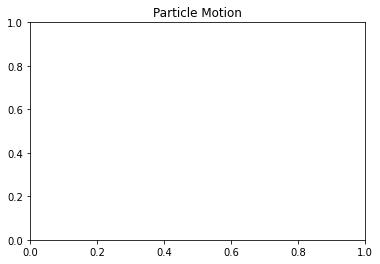

In [345]:
anim